# CRAG: Corrective RAG

이번 튜토리얼은 **Corrective RAG (CRAG)** 전략을 사용하여 RAG 기반 시스템을 개선하는 방법을 다룹니다. 

CRAG는 검색된 문서들에 대한 자기 반성(self-reflection) 및 자기 평가(self-evaluation) 단계를 포함하여, 검색-생성 파이프라인을 정교하게 다루는 접근법입니다.

![crag](./assets/langgraph-crag.png)

---

**CRAG 란?**

**Corrective-RAG (CRAG)** 는 RAG(Retrieval Augmented Generation) 전략에서 **검색 과정에서 찾아온 문서를 평가하고, 지식을 정제(refine) 하는 단계를 추가한 방법론**입니다. 이는 생성에 앞서 검색 결과를 점검하고 필요하다면 보조적인 검색을 수행하며, 최종적으로 품질 높은 답변을 생성하기 위한 일련의 프로세스를 포함합니다.

CRAG의 핵심 아이디어는 다음과 같습니다. 

[논문(Corrective Retrieval Augmented Generation) 링크](https://arxiv.org/pdf/2401.15884.pdf)

1. 검색된 문서 중 하나 이상이 사전 정의된 관련성 임계값(retrieval validation score) 을 초과하면 생성 단계로 진행합니다.
2. 생성 전에 지식 정제 단계를 수행합니다.
3. 문서를 "knowledge strips" 로 세분화합니다. (여기서, 문서 검색 결과수, `k` 를 의미합니다.)
4. 각 지식 스트립을 평가하고 관련성 여부를 score 로 평가합니다. (여기서는 문서 chunk 단위로 평가합니다.)
5. 모든 문서가 관련성 임계값 이하이거나 평가 결과 신뢰도가 낮을 경우, 추가 데이터 소스(예: 웹 검색)로 보강합니다.
6. 웹 검색을 통한 보강 시, 쿼리 재작성(Query-Rewrite) 을 통해 검색 결과를 최적화합니다.

---

**주요 내용**

이 튜토리얼에서는 LangGraph를 활용하여 CRAG 접근법의 일부 아이디어를 구현합니다.

여기서는 **지식 정제 단계는 생략**하고, 필요하다면 노드로 추가할 수 있는 형태로 설계합니다.  

또한, **관련 있는 문서가 하나도 없으면** 웹 검색을 활용하여 검색을 보완할 것입니다. 

웹 검색에는 [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/)를 사용하고, 검색 최적화를 위해 질문 재작성(Question Re-writing) 을 도입합니다.

---

**주요 단계 개요**

- **Retrieval Grader**: 검색된 문서의 관련성을 평가
- **Generate**: LLM을 통한 답변 생성
- **Question Re-writer**: 질문 재작성을 통한 검색 질의 최적화
- **Web Search Tool**: Tavily Search를 통한 웹 검색 활용
- **Create Graph**: LangGraph를 통한 CRAG 전략 그래프 생성
- **Use the graph**: 생성된 그래프를 활용하는 방법

---

**참고**

- [LangGraph CRAG 튜토리얼 (공식 문서)](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/)

## 환경 설정



In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retriever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

**실습에 활용한 문서**

소프트웨어정책연구소(SPRi) - 2023년 12월호

- 저자: 유재흥(AI정책연구실 책임연구원), 이지수(AI정책연구실 위촉연구원)
- 링크: https://spri.kr/posts/view/23669
- 파일명: `SPRI_AI_Brief_2023년12월호_F.pdf`

_실습을 위해 다운로드 받은 파일을 `data` 폴더로 복사해 주시기 바랍니다_

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(["/Users/frodo/Documents/project/langchain-kr/17-LangGraph/03-Use-Cases/assets/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever 와 chain을 생성
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

## 검색된 문서의 관련성 평가 (Question-Retrieval Evaluation)

검색된 문서의 관련성 평가는 검색된 문서가 질문과 관련이 있는지 여부를 평가하는 단계입니다.

먼저, 검색된 문서를 평가하기 위한 평가기(`retrieval-grader`) 를 생성합니다.

In [4]:
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_teddynote.models import get_model_name, LLMs
from pydantic import BaseModel, Field

# 모델 이름 가져오기
# MODEL_NAME = get_model_name(LLMs.GPT4)
MODEL_NAME = "gemini-2.0-flash-001"


# 검색된 문서의 관련성 여부를 이진 점수로 평가하는 데이터 모델
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM 초기화
# llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)

# GradeDocuments 데이터 모델을 사용하여 구조화된 출력을 생성하는 LLM
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# 채팅 프롬프트 템플릿 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Retrieval 평가기 초기화
retrieval_grader = grade_prompt | structured_llm_grader

`retrieval_grader` 를 사용해서 문서를 평가합니다. 

여기서는 문서의 집합이 아닌 1개의 단일 문서에 대한 평가를 수행합니다.

결과는 단일 문서에 대한 관련성 여부가 (yes/no) 로 반환됩니다.

In [5]:
# 질문 정의
question = "삼성전자가 개발한 생성AI 에 대해 설명하세요."

# 문서 검색
docs = pdf_retriever.invoke(question)

# 검색된 문서 중 1번 index 문서의 페이지 내용을 추출
doc_txt = docs[1].page_content

# 검색된 문서와 질문을 사용하여 관련성 평가를 실행하고 결과 출력
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


## 답변 생성 체인

답변 생성 체인은 검색된 문서를 기반으로 답변을 생성하는 체인입니다.

우리가 알고 있는 일반적인 Naive RAG 체인 입니다.

In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI


# LangChain Hub에서 RAG 프롬프트를 가져와 사용
prompt = hub.pull("teddynote/rag-prompt")

# LLM 초기화
# llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)
llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


# 체인 생성
rag_chain = prompt | llm | StrOutputParser()


# 체인 실행 및 결과 출력
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

제공된 문서에서 삼성전자가 개발한 생성AI에 대한 정보는 찾을 수 없습니다.


## 쿼리 재작성(Question Re-writer)

쿼리 재작성은 웹 검색을 최적화하기 위해 질문을 재작성하는 단계입니다.

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# LLM 설정
# llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
llm = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)

# Query Rewrite 시스템 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized 
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# 프롬프트 정의
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Question Re-writer 체인 초기화
question_rewriter = re_write_prompt | llm | StrOutputParser()

`question_rewriter` 를 사용해서 질문을 재작성합니다.

In [10]:
# 실행 및 결과 확인
print(f'[원본 질문]: "{question}"')
print("[쿼리 재작성]:", question_rewriter.invoke({"question": question}))

[원본 질문]: "삼성전자가 개발한 생성AI 에 대해 설명하세요."
[쿼리 재작성]: Here are a few options for re-writing the question, depending on the specific intent:

**Option 1 (Focus on the AI itself):**

*   **Search Query:** "Samsung generative AI model details"

**Option 2 (Focus on the capabilities):**

*   **Search Query:** "What can Samsung's generative AI do?"

**Option 3 (More general overview):**

*   **Search Query:** "Samsung's generative AI: overview and features"

**Reasoning:**

The original question, translated, is "Explain the generative AI developed by Samsung Electronics."  While understandable, it's not ideal for search.  The re-written options aim to:

*   **Use keywords:** "generative AI," "Samsung," "model," "features," "overview" are all common terms.
*   **Be concise:** Search engines prefer shorter queries.
*   **Imply the desired information:** "Details," "what can it do," and "overview and features" all guide the search engine towards relevant results.


## 웹 검색 도구

**웹 검색 도구**는 컨텍스트를 보강하기 위한 용도로 사용됩니다.

- **웹 검색의 필요성**: 모든 문서가 관련성 임계값을 충족하지 않거나 평가자가 확신이 없을 때, 웹 검색을 통해 추가 데이터를 확보합니다.
- **Tavily Search 사용**: Tavily Search를 활용하여 웹 검색을 수행합니다. 이는 검색 쿼리를 최적화하고, 보다 관련성 높은 결과를 제공합니다.
- **질문 재작성**: 웹 검색을 최적화하기 위해 질문을 재작성하여 검색 쿼리를 개선합니다.

In [11]:
# 웹 검색 도구 초기화
from langchain_teddynote.tools.tavily import TavilySearch

# 최대 검색 결과를 3으로 설정
web_search_tool = TavilySearch(max_results=3)

In [56]:
query = 'Here are a few options, depending on the nuance you want to capture:*   **What is the name of the generative AI developed by Samsung?** (This is a direct and clear translation.)*   **Samsung generative AI: What is it called?** (This is concise and uses common search patterns.) *   **What is the official name of Samsungs generative AI model?** (This adds '

In [57]:
# 웹 검색 도구 실행
results = web_search_tool.invoke({"query": question})
print(results)

[{'title': "삼성전자, 자체 개발한 생성형 AI '삼성 가우스2' 공개 - ZDNet korea", 'url': 'https://zdnet.co.kr/view/?no=20241121083205', 'content': '또한 "삼성전자 고유의 생성형 AI 모델인 \'삼성 가우스2\'를 공개하고, 향상된 성능과 효율, 그리고 활용 방안에 대해 설명할 예정"이라며 "이를 통해 업무 생산성 향상과 단계적 제품 적용으로 더욱 편리하고 차별화된 고객 경험을 제공할 것"이라고 말했다. 삼성전자는 키노트 발표에서 지난해 처음 공개한 생성형 AI 모델 \'삼성 가우스1(Samsung Gauss1)\'의 후속 모델인 \'삼성 가우스2(Samsung Gauss2)\'를 공개했다. 실제로 \'삼성 가우스\'는 이런 맞춤형 개발의 장점을 살려 직원들의 다양한 업무에서 활용되고 있다. 삼성 가우스 포탈(Samsung Gauss Portal)은 \'삼성 가우스\'의 대화형 AI 서비스로 ▲문서 요약 ▲번역 ▲메일 작성 등 DX부문 직원들의 다양한 사무 업무를 빠르고 효율적으로 처리할 수 있도록 지원하고 있다. 삼성전자는 향후 \'삼성 가우스2\'를 통해 \'코드아이(code.i)\'서비스의 지속적인 성능 개선, \'삼성 가우스 포탈(Samsung Gauss Portal)\'의 자연어 질의응답 성능 향상, 표와 차트의 이해, 이미지 생성 등 멀티모달 기능을 지원해 사내 생산성 향상에 기여할 계획이다.', 'score': 0.82560414, 'raw_content': '삼성전자, 자체 개발한 생성형 AI \'삼성 가우스2\' 공개\n21일 \'삼성 개발자 콘퍼런스 코리아\'서 최신 기술과 비전 소개\n디지털경제입력 :2024/11/21 10:00\n삼성전자는\xa0\'삼성 개발자 콘퍼런스 코리아 2024(Samsung Developer Conference Korea 2024, SDC24 Korea)\'를 온라인으로 개최했다고 21일 밝혔다.\n삼성전자는 소프트웨어 개발자들과 소통

In [12]:
# 웹 검색 도구 실행
results = web_search_tool.invoke({"query": question})
print(results)

[{'title': "삼성전자, 자체 개발한 생성형 AI '삼성 가우스2' 공개 - ZDNet korea", 'url': 'https://zdnet.co.kr/view/?no=20241121083205', 'content': '또한 "삼성전자 고유의 생성형 AI 모델인 \'삼성 가우스2\'를 공개하고, 향상된 성능과 효율, 그리고 활용 방안에 대해 설명할 예정"이라며 "이를 통해 업무 생산성 향상과 단계적 제품 적용으로 더욱 편리하고 차별화된 고객 경험을 제공할 것"이라고 말했다. 삼성전자는 키노트 발표에서 지난해 처음 공개한 생성형 AI 모델 \'삼성 가우스1(Samsung Gauss1)\'의 후속 모델인 \'삼성 가우스2(Samsung Gauss2)\'를 공개했다. 실제로 \'삼성 가우스\'는 이런 맞춤형 개발의 장점을 살려 직원들의 다양한 업무에서 활용되고 있다. 삼성 가우스 포탈(Samsung Gauss Portal)은 \'삼성 가우스\'의 대화형 AI 서비스로 ▲문서 요약 ▲번역 ▲메일 작성 등 DX부문 직원들의 다양한 사무 업무를 빠르고 효율적으로 처리할 수 있도록 지원하고 있다. 삼성전자는 향후 \'삼성 가우스2\'를 통해 \'코드아이(code.i)\'서비스의 지속적인 성능 개선, \'삼성 가우스 포탈(Samsung Gauss Portal)\'의 자연어 질의응답 성능 향상, 표와 차트의 이해, 이미지 생성 등 멀티모달 기능을 지원해 사내 생산성 향상에 기여할 계획이다.', 'score': 0.82560414, 'raw_content': '삼성전자, 자체 개발한 생성형 AI \'삼성 가우스2\' 공개\n21일 \'삼성 개발자 콘퍼런스 코리아\'서 최신 기술과 비전 소개\n디지털경제입력 :2024/11/21 10:00\n삼성전자는\xa0\'삼성 개발자 콘퍼런스 코리아 2024(Samsung Developer Conference Korea 2024, SDC24 Korea)\'를 온라인으로 개최했다고 21일 밝혔다.\n삼성전자는 소프트웨어 개발자들과 소통

## 상태(State)

먼저, CRAG 그래프를 위한 상태를 정의합니다.

`web_search` 는 웹 검색을 활용할지 여부를 나타내는 상태입니다. yes 또는 no 로 표현합니다 (yes: 웹 검색 필요, no: 필요 없음)

In [13]:
from typing import Annotated, List
from typing_extensions import TypedDict


# 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]

## 노드

CRAG 그래프에 활용할 노드를 정의합니다.

In [35]:
from langchain.schema import Document


# 문서 검색 노드
def retrieve(state: GraphState):
    print("\n==== RETRIEVE ====\n")
    question = state["question"]

    # 문서 검색 수행
    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


# 답변 생성 노드
def generate(state: GraphState):
    print("\n==== GENERATE ====\n")
    question = state["question"]
    documents = state["documents"]

    # RAG를 사용한 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# 문서 평가 노드
def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    question = state["question"]
    documents = state["documents"]

    # 필터링된 문서
    filtered_docs = []
    relevant_doc_count = 0

    for d in documents:
        # Question-Document 의 관련성 평가
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score

        if grade == "yes":
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            # 관련 있는 문서를 filtered_docs 에 추가
            filtered_docs.append(d)
            relevant_doc_count += 1
        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")
            continue

    # 관련 문서가 없으면 웹 검색 수행
    web_search = "Yes" if relevant_doc_count == 0 else "No"
    return {"documents": filtered_docs, "web_search": web_search}


# 쿼리 재작성 노드
def query_rewrite(state: GraphState):
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


# 웹 검색 노드
def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    question = state["question"].replace("'", "")
    documents = state["documents"]

    # 웹 검색 수행
    docs = web_search_tool.invoke({"query": question})
    # 검색 결과를 문서 형식으로 변환
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}

## 조건부 엣지에 활용할 함수

`decide_to_generate` 함수는 관련성 평가를 마친 뒤, 웹 검색 여부에 따라 다음 노드로 라우팅하는 역할을 수행합니다.

`web_search` 가 `Yes` 인 경우 `query_rewrite` 노드에서 쿼리를 재작성 한 뒤 웹 검색을 수행합니다.

만약, `web_search` 가 `No` 인 경우는 `generate` 를 수행하여 최종 답변을 생성합니다.

In [36]:
def decide_to_generate(state: GraphState):
    # 평가된 문서를 기반으로 다음 단계 결정
    print("==== [ASSESS GRADED DOCUMENTS] ====")
    # 웹 검색 필요 여부
    web_search = state["web_search"]

    if web_search == "Yes":
        # 웹 검색으로 정보 보강이 필요한 경우
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ===="
        )
        # 쿼리 재작성 노드로 라우팅
        return "query_rewrite"
    else:
        # 관련 문서가 존재하므로 답변 생성 단계(generate) 로 진행
        print("==== [DECISION: GENERATE] ====")
        return "generate"

## 그래프 생성

이제 노드를 정의하고 엣지를 연결하여 그래프를 완성합니다.

In [37]:
from langgraph.graph import END, StateGraph, START

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)

# 엣지 연결
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

그래프를 시각화합니다.

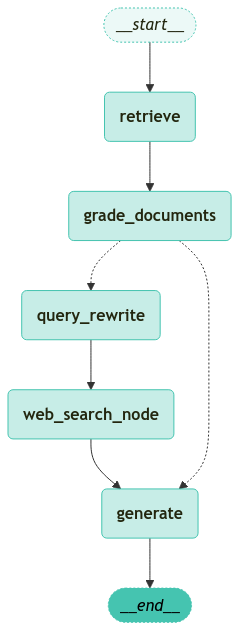

In [38]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

이제 그래프를 실행하고 결과를 확인합니다.

In [39]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=40, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 스트리밍 형식으로 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    # ["retrieve", "grade_documents", "query_rewrite", "web_search_node", "generate"],
)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

==== [REWRITE QUERY] ====


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Here are a few options, depending on the nuance you want to capture:

*   **What is the name of the generative AI developed by Samsung?** (This is a direct and clear translation.)
*   **Samsung generative AI: What is it 

HTTPError: 400 Client Error: Bad Request for url: https://api.tavily.com/search

In [30]:
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=30, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "2024년 노벨문학상 수상자의 이름은?",
}

그래프를 실행합니다.

In [26]:
# 그래프 실행
invoke_graph(app, inputs, config)


==== RETRIEVE ====


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='▹ 빌 게이츠, AI 에이전트로 인한 컴퓨터 사용의 패러다임 변화 전망································13
▹ 유튜브, 2024년부터 AI 생성 콘텐츠 표시 의무화····························································14
3. 기술/연구
▹ 영국 과학혁신기술부, AI 안전 연구소 설립 발표······························································15' metadata={'source': '/Users/frodo/Documents/project/langchain-kr/17-LangGraph/03-Use-Cases/assets/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': '/Users/frodo/Documents/project/langchain-kr/17-LangGraph/03-Use-Cases/assets/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}
page_content='£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구

스트리밍 형식으로 그래프를 실행합니다.

In [31]:
# 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "generate"],
)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

==== [REWRITE QUERY] ====


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Here are a few options for improved search queries, depending on the specific intent:

*   **Best, most direct:** "Who won the 2024 Nobel Prize in Literature?"
*   **If the user might be unsure if the prize has been awar